#**Identification Emotions by Bidirectional GRU**

It is required to identify the emotions that a person feels when writing a text or a sentence. To achieve this we found a database with almost 400K of data which are structured as follows.

*   **ID:** Row identifier
*   **Text:** Text which contains information to identify the emotions felt by the author.
*   **Label:** Category in which the felt emotion is classified: Sadness (0), Joy (1), Love (2), Anger (3), Fear (4), and Surprise (5)

###**About the dataset**
Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

##**Project objective**
The objective of the project is to identify the emotion that a person feels when writing a text. To achieve this, a neural network based on GRU will be implemented in order to make individual or collective predictions.

##Importing Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

##Loading Text

In [4]:
df = pd.read_csv("text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
# Drop the Unamed columns
df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
# View the new shape, now we have 2 columns
print(f'The Shape Of Data Is : {df.shape}')

The Shape Of Data Is : (416809, 2)


In [8]:
# Count the null data
df.isnull().sum()

text     0
label    0
dtype: int64

In [9]:
# View the duplicated data
df.duplicated().sum()

686

In [10]:
# Remove the duplicated data
df = df.drop_duplicates()

In [11]:
# Rename Columns
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


##View the Data

In [13]:
# Lets Rename Label also {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
# Do this to view the graph with the emotions

df['Label'] = df['Label'].replace(0,'Sadness')
df['Label'] = df['Label'].replace(1,'Joy')
df['Label'] = df['Label'].replace(2,'Love')
df['Label'] = df['Label'].replace(3,'Anger')
df['Label'] = df['Label'].replace(4,'Fear')
df['Label'] = df['Label'].replace(5,'Surprise')

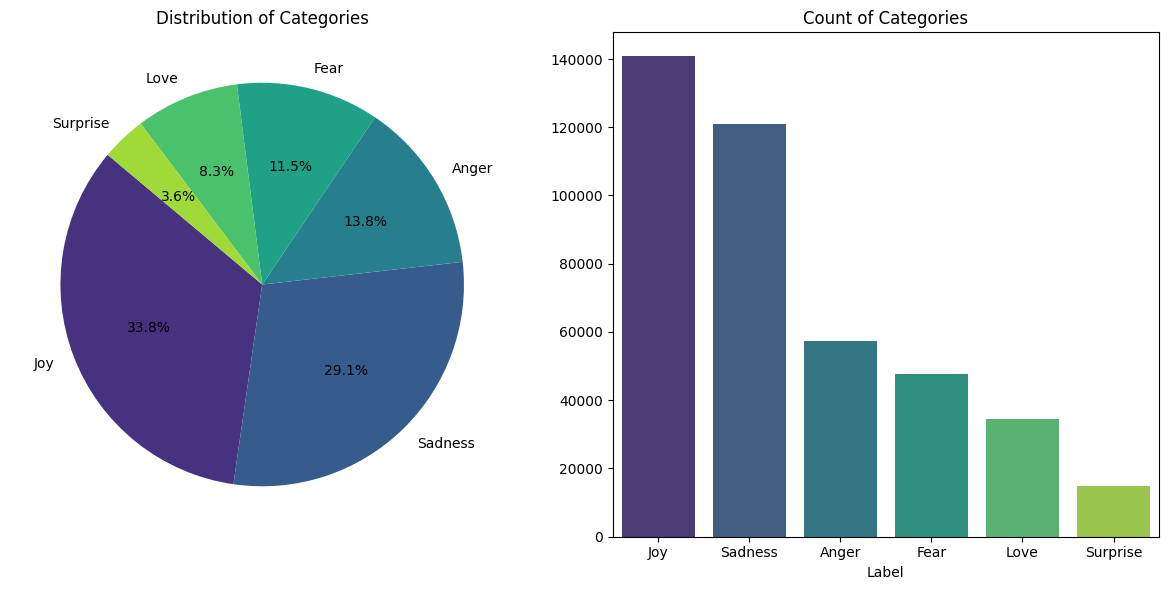

In [15]:
# Value Count Of Label
count = df['Label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, hue=count.index, ax=axs[1], palette="viridis", legend=False)
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# We change the labels again to be able to work with the model
df['Label'] = df['Label'].replace('Sadness',0)
df['Label'] = df['Label'].replace('Joy',1)
df['Label'] = df['Label'].replace('Love',2)
df['Label'] = df['Label'].replace('Anger',3)
df['Label'] = df['Label'].replace('Fear',4)
df['Label'] = df['Label'].replace('Surprise',5)

##Cleaning Data

###Remove chat words

Some rows of our DataSet contain American abbreviations and jargons, for this reason we must create an object which contains the translations to these jargons.

In [17]:
# Chat words and their meanings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}



In [19]:
# Function to replace the chat words
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['Text'] = df['Text'].apply(replace_chat_words)

###Remove URL's

In [20]:
# Import Basis Needed Libaries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (uncomment the following line if not already downloaded)?
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# Remove URLs
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


###Remove Special Characters and Punctuation

In [22]:
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


###Remove whitespaces

In [24]:
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


###Remove numeric values

In [26]:
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


###Remove Non-alpha Numeric

In [27]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### LowerCase

In [28]:
df['Text'] = df['Text'].str.lower()

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


###Remove Stop Words
In this part of the code, a text preprocessing step is being performed that involves removing empty words (stop words) from the text in the DataFrame. The stop words are common words that generally do not contribute much to the meaning of the text, such as “the”, “is”, “at”, etc.

In [29]:
# Step 8: Remove stop words
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


## Train Test Split

Once we have all the dataset cleaned and transformed in the best way so that it can be processed by GRU, the next step is to split our dataset to have the training and test data.

In [ ]:
X = df['Text']
y = df['Label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (332898,)
X_test shape: (83225,)
y_train shape: (332898,)
y_test shape: (83225,)


##Transform text to Tokens

The GRU does not receive text as such, in order to pass our data to the model we will create later we have to pass the text to tokenize (Tokenizing a text is the process of breaking it into smaller units, called tokens. These tokens can be individual words, parts of words (subtokens) or even individual characters).

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


Once we have the tokenized text, the next step is to pass that text to a pad sequence, which will transform our data into arrays that will be read by the neural network.

In [ ]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [ ]:
# Embedding Input Size / Vocabulary Size
input_Size = np.max(X_train_padded) + 1
input_Size

50000

##Create the Model RGU

This code is the construction of a recurrent neural network (RNN) using the Keras framework. Let's break down each part:



1.   Sequential: A sequential model is initialized in Keras, which allows stacking layers sequentially.
2.   Embedding layer: An embedding layer is added to convert words into real value vectors.
3.   Dropout: Dropout is applied to avoid overfitting by randomly disabling some units during training.
4.   Bidirectional GRU layers: Two layers of bidirectional GRU units are added to capture context information both before and after in the input sequence.
5.   Batch Normalization: Activations are normalized to stabilize training and improve convergence speed.
6.   Dense output layer: A dense output layer with softmax activation is added for output classification.
7.   Compile: The model is compiled with an optimizer, a loss function and evaluation metrics.
8.   Summary: A summary of the model is printed showing its architecture and the number of trainable parameters.



In [ ]:
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=input_Size, output_dim=50, input_length=maxlen))

# Dropout
model.add(Dropout(0.5))

# Add Bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#Batch Normalization
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 79, 50)            2500000   
                                                                 
 dropout_1 (Dropout)         (None, 79, 50)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 79, 240)           123840    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 79, 128)           117504    
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 79, 128)           512       
 chNormalization)                                                
                                                      

###Train the model

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/5
222/222 [==============================] - 65s 250ms/step - loss: 0.4678 - accuracy: 0.8193 - val_loss: 0.6715 - val_accuracy: 0.8761
Epoch 2/5
222/222 [==============================] - 46s 207ms/step - loss: 0.1131 - accuracy: 0.9368 - val_loss: 0.1204 - val_accuracy: 0.9324
Epoch 3/5
222/222 [==============================] - 42s 190ms/step - loss: 0.0968 - accuracy: 0.9409 - val_loss: 0.0943 - val_accuracy: 0.9347
Epoch 4/5
222/222 [==============================] - 42s 190ms/step - loss: 0.0914 - accuracy: 0.9419 - val_loss: 0.0948 - val_accuracy: 0.9368
Epoch 5/5
222/222 [==============================] - 42s 189ms/step - loss: 0.0886 - accuracy: 0.9428 - val_loss: 0.0955 - val_accuracy: 0.9357


###Evaluate the model

In [ ]:
# Evaluate Test Data
model.evaluate(X_test_padded, y_test)

2601/2601 [==============================] - 29s 11ms/step - loss: 0.0955 - accuracy: 0.9357


[0.09552855044603348, 0.9356803894042969]

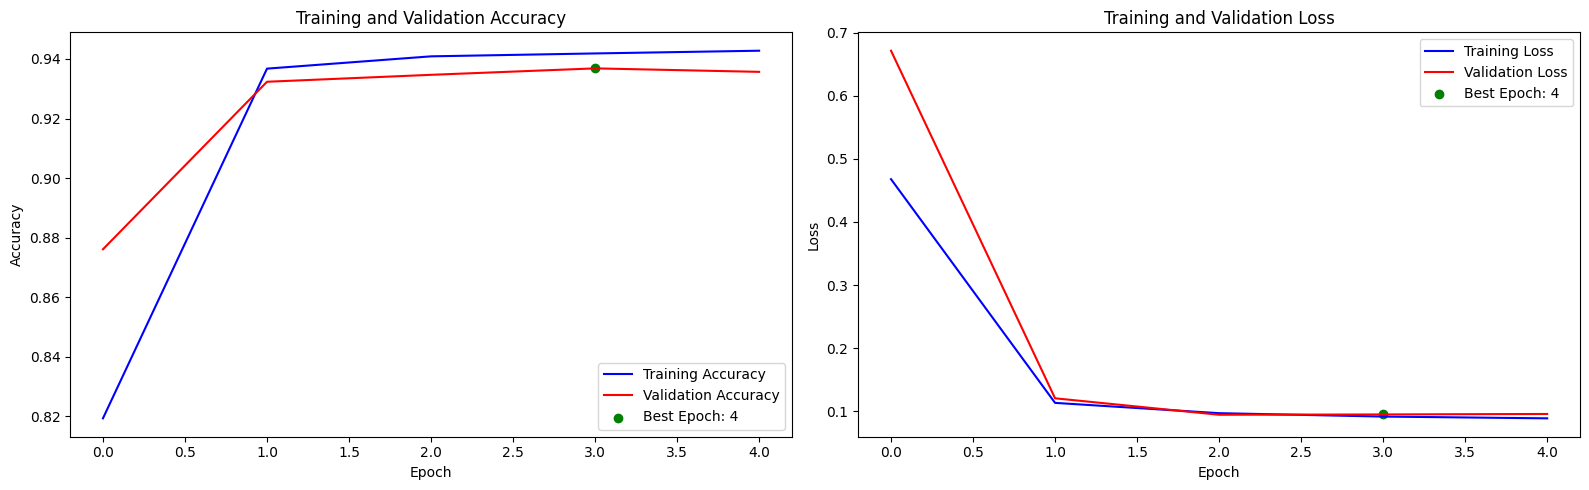

In [ ]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

##Individual Test

In [ ]:
# Texto individual
texto_individual = "feel angry"

# Tokenizar el texto individual
texto_secuencia = tokenizer.texts_to_sequences([texto_individual])

# Hacer padding de la secuencia
texto_padded = pad_sequences(texto_secuencia, maxlen=maxlen, padding='post')

# Hacer la predicción
prediccion = model.predict(texto_padded)

print("Predicción:", prediccion)

1/1 [==============================] - 0s 46ms/step
Predicción: [[0.05336124 0.0412002  0.03198    0.79706335 0.03345321 0.04294196]]


In [ ]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Obtener el índice de la clase con la probabilidad más alta
indice_clase_predicha = np.argmax(prediccion)

# Obtener la emoción correspondiente al índice de la clase predicha
emocion_predicha = emotion_map[indice_clase_predicha]

print("Emoción predicha:", emocion_predicha)

Emoción predicha: anger


In [ ]:
import joblib

# Guardar el modelo en formato .joblib
joblib.dump(model, 'modelo_gru.joblib')


['modelo_gru.joblib']